## GEE

In [1]:
import ee
import geemap
ee.Initialize()

In [2]:
xmin,ymin,xmax,ymax = [-75.249597, -10.770447, -74.966013, -10.503883]
pol = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])

uriBase = 'gs://rgee_dev/COG/'
collection = ee.ImageCollection(ee.List([
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6970_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F7000_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6960_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6990_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6980_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F7000_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F6990_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6950_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F7010_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F7020_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F6980_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_24988_FBD_F7010_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F6970_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F6970_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26257_FBS_F6970_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26257_FBS_F6960_RT1.cog.tif')
]))

mosaic = collection.mosaic()
dem = mosaic.clip(pol).select("B0").toFloat().rename("B14").reproject('EPSG:4326', None, 10)
slope = ee.Terrain.slope(dem).select("slope").toFloat().rename("B13")

In [3]:
d_s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')\
              .filterDate('2020-06-01', '2020-07-30')\
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
              .filterBounds(pol)\
              .first()\
              .select("B2","B3","B4","B8")\
              .clip(pol)
#.select("B1","B2","B3","B4","B5","B6","B7","B8","B9","B10","B11","B12")\

# b1 = d_s2.select("B1").multiply(0.0001).toFloat()
# b2 = d_s2.select("B2").multiply(0.0001).toFloat()
# b3 = d_s2.select("B3").multiply(0.0001).toFloat()
# b4 = d_s2.select("B4").multiply(0.0001).toFloat()
# b5 = d_s2.select("B5").multiply(0.0001).toFloat()
# b6 = d_s2.select("B6").multiply(0.0001).toFloat()
# b7 = d_s2.select("B7").multiply(0.0001).toFloat()
# b8 = d_s2.select("B8").multiply(0.0001).toFloat()
# b9 = d_s2.select("B9").multiply(0.0001).toFloat()
# b10 = d_s2.select("B10").multiply(0.0001).toFloat()
# b11 = d_s2.select("B11").multiply(0.0001).toFloat()
# b12 = d_s2.select("B12").multiply(0.0001).toFloat()

b2 = d_s2.select("B2").multiply(0.0001).toFloat()
b3 = d_s2.select("B3").multiply(0.0001).toFloat()
b4 = d_s2.select("B4").multiply(0.0001).toFloat()
b8 = d_s2.select("B8").multiply(0.0001).toFloat()

# dataset = b1.addBands(b2).addBands(b3).addBands(b4).addBands(b5).addBands(b6).addBands(b7).addBands(b8).addBands(b9).addBands(b10).addBands(b11).addBands(b12).addBands(slope).addBands(dem)
dataset = b2.addBands(b3).addBands(b4).addBands(b8).addBands(slope).addBands(dem)

In [8]:
Map = geemap.Map()
Map.centerObject(pol, 12)
Map.addLayer(dataset.select("B13"), {}, 'slope')
Map.addLayer(dataset.select("B14"), {}, 'dem')

In [13]:
outputBucket = 'rgee_dev'
imageFilePrefix = 'tesis4/ld'
imageTask = ee.batch.Export.image.toCloudStorage(
  image=dataset,
  description='Image Export',
  fileNamePrefix=imageFilePrefix,
  bucket=outputBucket,
  scale=10,
  fileFormat='GeoTIFF',
  region=pol.getInfo()['coordinates'],
  maxPixels=2e8
)
imageTask.start()

In [14]:
import time
while imageTask.active():
  print('Polling for task (id: {}).'.format(imageTask.id))
  time.sleep(5)

Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id: NCN6MGIMD4TAMSQYDFXCS373).
Polling for task (id

In [1]:
import rasterio
import numpy as np
from google.cloud import storage
import scipy.ndimage

storage_client = storage.Client()
bucket = storage_client.bucket('rgee_dev')
blob = bucket.blob('tesis4/ld.tif')
blob.download_to_filename('/tmp/ld.tif')

# Open the file:
dataset = rasterio.open('/tmp/ld.tif')

image_data = dataset.read()

In [2]:
def rellenar_nan(parche):
    for i in range(parche.shape[0]):
        # Obtener la banda actual
        banda = parche[i, :, :]
        
        # Encontrar los índices de los valores NaN
        mask_nan = np.isnan(banda)
        
        # Calcular las distancias a los valores no-NaN más cercanos y obtener los índices
        distancias, indices = scipy.ndimage.distance_transform_edt(mask_nan, return_indices=True)
        
        # Crear una copia de la banda para evitar sobrescribir valores que todavía necesitamos para rellenar otros NaNs
        banda_copia = banda.copy()
        
        # Rellenar los valores NaN
        banda[mask_nan] = banda_copia[indices[0, mask_nan], indices[1, mask_nan]]
        
        # Actualizar el parche con la banda procesada
        parche[i, :, :] = banda
        
    return parche


def cortar_en_parches(image_data, size=128):
    n_bandas, width, height = image_data.shape
    
    # Calculamos cuántos parches caben en la imagen en ambas direcciones
    n_parches_x = width // size
    n_parches_y = height // size
    
    parches = []
    
    for i in range(n_parches_x):
        for j in range(n_parches_y):
            # Cortamos la imagen
            parche = image_data[:, i*size:(i+1)*size, j*size:(j+1)*size]
            parche_rellenado = rellenar_nan(parche)
            parches.append(parche_rellenado)
    return parches

parches = cortar_en_parches(image_data)

In [3]:
from dataset import DatasetLandslideEval
from model import LandslideModel
import torch

def get_model_pl(model_path):
    model = LandslideModel()
    return  model.load_from_checkpoint(checkpoint_path=model_path)

In [4]:
model_path = r'../models/unet_vanilla_6b_l4s.ckpt'
model = get_model_pl(model_path)
dataset_eval = DatasetLandslideEval(parches)

In [5]:
loader = torch.utils.data.DataLoader(dataset_eval, batch_size=16, shuffle=False, num_workers=0)

In [8]:
# 2. Iterar sobre el DataLoader y hacer predicciones
model.eval()  # Poner el modelo en modo evaluación
all_predictions = []

with torch.no_grad():
    for images in loader:  # Aquí, estamos desempaquetando las imágenes y las máscaras, pero solo usamos las imágenes
        predictions = model(images)
        # normalize predictions to 0 and 1
        predictions = torch.sigmoid(predictions)
        # convert to numpy array
        predictions = predictions.cpu().numpy()
        all_predictions.append(predictions)

In [60]:
def reconstruir_mascara(parches, size, original_shape):
    _, height, width = original_shape
    mascara_reconstruida = np.zeros(original_shape, dtype=parches[0].dtype)
    
    n_parches_x = -(-width // size)
    n_parches_y = -(-height // size)
    
    contador = 0
    for i in range(n_parches_x):
        for j in range(n_parches_y):
            if contador >= len(parches):
                print("Advertencia: No hay suficientes parches para llenar la imagen. Se rellenará con ceros.")
                break
            
            parche = parches[contador]
            
            if parche.ndim == 3:
                parche = parche[0]
                
            espacio_restante_x = min(size, width - i * size)
            espacio_restante_y = min(size, height - j * size)
            
            parche_ajustado = parche[:espacio_restante_x, :espacio_restante_y]
            
            mascara_reconstruida[:, i*size:i*size + espacio_restante_x, j*size:j*size + espacio_restante_y] = parche_ajustado
            contador += 1
            
    return mascara_reconstruida

parches_aplanados = [parche for batch in all_predictions for parche in batch]
mascara_reconstruida = reconstruir_mascara(parches_aplanados, size, original_shape)
print(mascara_reconstruida.shape)  # Debería ser (1, 2949, 3104)

Advertencia: No hay suficientes parches para llenar la imagen. Se rellenará con ceros.
Advertencia: No hay suficientes parches para llenar la imagen. Se rellenará con ceros.
(1, 2949, 3104)


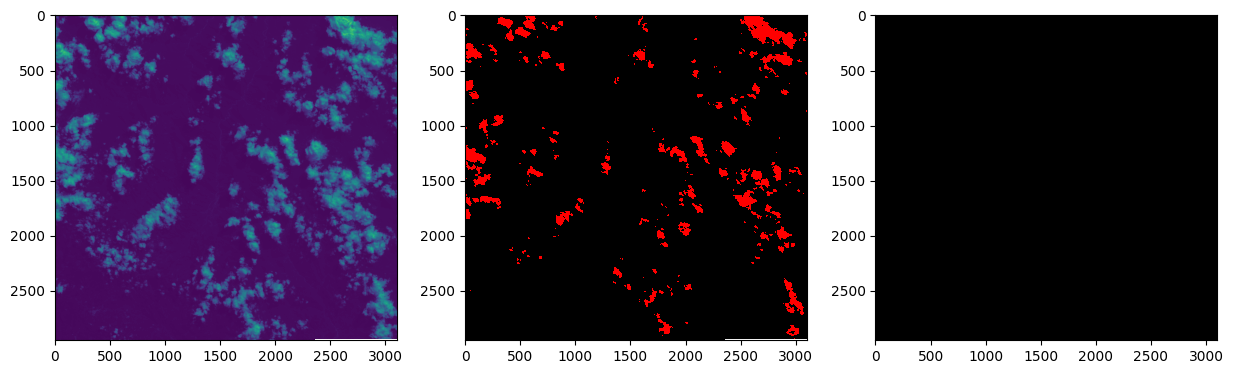

In [63]:
# plot results
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_results(image, mask, prediction):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[1].imshow(mask, cmap=ListedColormap(['black', 'red']), vmin=0, vmax=1)
    ax[2].imshow(prediction, cmap=ListedColormap(['black', 'red']), vmin=0, vmax=1)
    plt.show()

image = dataset.read(1)
mask = dataset.read(2)
prediction = mascara_reconstruida[0]

plot_results(image, mask, prediction)

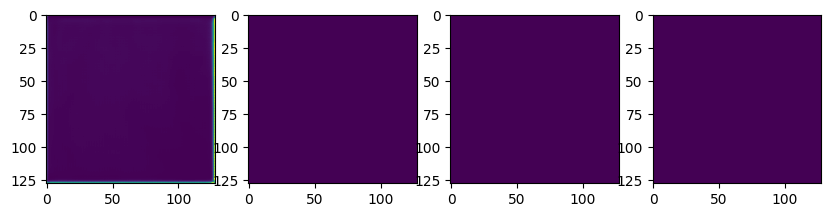

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(all_predictions[219][0,:])
ax[1].imshow(all_predictions[219][0,:] > 0.5)
ax[2].imshow(all_predictions[219][0,:] > 0.7)
ax[3].imshow(all_predictions[219][0,:] > 0.9)
plt.show()

In [22]:
# Instantiate the writer.
PATCH_WIDTH , PATCH_HEIGHT = [128,128]
outputImageFile = 'gs://' + outputBucket + '/tesis/ld_out.TFRecord'
writer = tf.io.TFRecordWriter(outputImageFile)
curPatch = 1
for  prediction in predictions:
  patch = prediction.squeeze().T.flatten().tolist()

  if (len(patch) == PATCH_WIDTH * PATCH_HEIGHT):
    print('Done with patch ' + str(curPatch) + '...')
    # Create an example
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'crop_prob': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch))
        }
      )
    )

    writer.write(example.SerializeToString())
    curPatch += 1
writer.close()

Done with patch 1...
Done with patch 2...
Done with patch 3...
Done with patch 4...
Done with patch 5...
Done with patch 6...
Done with patch 7...
Done with patch 8...
Done with patch 9...
Done with patch 10...
Done with patch 11...
Done with patch 12...
Done with patch 13...
Done with patch 14...
Done with patch 15...
Done with patch 16...
Done with patch 17...
Done with patch 18...
Done with patch 19...
Done with patch 20...
Done with patch 21...
Done with patch 22...
Done with patch 23...
Done with patch 24...
Done with patch 25...
Done with patch 26...
Done with patch 27...
Done with patch 28...
Done with patch 29...
Done with patch 30...
Done with patch 31...
Done with patch 32...
Done with patch 33...
Done with patch 34...
Done with patch 35...
Done with patch 36...
Done with patch 37...
Done with patch 38...
Done with patch 39...
Done with patch 40...
Done with patch 41...
Done with patch 42...
Done with patch 43...
Done with patch 44...
Done with patch 45...
Done with patch 46.

In [33]:
def predict_input_fn(fileNames, side, bands):

  # Read `TFRecordDatasets`
  dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')
  featuresDict = {x:tf.io.FixedLenFeature([side, side], dtype=tf.float32) for x in bands}

  # Make a parsing function
  def parse_image(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
    return parsed_features

  def stack_images(features):
    nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))
    return nfeat

  dataset = dataset.map(parse_image, num_parallel_calls=4)
  dataset = dataset.map(stack_images, num_parallel_calls=4)
  dataset = dataset.batch(side*side)
  return dataset

In [6]:
from google.cloud import storage

def list_blobs(bucket_name, prefix=None):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix)
    return [blob.name for blob in blobs]

imageFilePrefix = 'tesis/ld'
filesList = list_blobs('rgee_dev', imageFilePrefix)

In [39]:
filesList

['tesis/ld.json', 'tesis/ld.tfrecord.gz', 'tesis/ld_out.TFRecord']

In [40]:
bucket_name = 'rgee_dev'
folder_name = 'tesis'
exportFilesList = [f"gs://{bucket_name}/{s}" for s in filesList if imageFilePrefix in s]
# Get the list of image files and the JSON mixer file.
imageFilesList = []
jsonFile = None
for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
        imageFilesList.append(f)
    elif f.endswith('.json'):
        jsonFile = f

In [41]:
imageFilesList

['gs://rgee_dev/tesis/ld.tfrecord.gz']

In [42]:
json_text = None
jsonFile = 'gs://rgee_dev/tesis/ld.json'
with tf.io.gfile.GFile(jsonFile, 'r') as f:
    json_text = f.read()
    mixer = json.loads(json_text)

In [55]:
mixer["projection"]["affine"]["doubleMatrix"]

[10.0, 0.0, 359880.0, 0.0, -10.0, 8854970.0]

In [43]:
with open("../models/model_resnet34_6b_ns.json", "r") as json_file:
    json_config = json_file.read()
model = tf.keras.models.model_from_json(json_config)
model.load_weights("../models/model_resnet34_6b_ns.h5")

In [44]:
fileNames = imageFilesList
side = 128
bands = ['B2', 'B3', 'B4', 'B13', 'B14', 'B15']
predict_db = predict_input_fn(fileNames=imageFilesList, side=128, bands=["B2", "B3", "B4", "B13", "B14", "B15"])

In [45]:
predictions = model.predict(predict_db)

1/1 [==============================] - 31s 31s/step


In [24]:
!gsutil ls -l {outputImageFile}

  15608754  2023-07-02T15:39:32Z  gs://rgee_dev/tesis/ld_out.TFRecord
TOTAL: 1 objects, 15608754 bytes (14.89 MiB)


In [2]:
# REPLACE WITH YOUR USERNAME:
USER_NAME = 'ryali93'
outputAssetID = 'users/' + USER_NAME + '/ld_out'
print('Writing to ' + outputAssetID)

Writing to users/ryali93/ld_out


In [26]:
# Start the upload. It step might take a while.
!earthengine upload image --asset_id={outputAssetID} {outputImageFile} {jsonFile}

Started upload task with ID: LI3VG7KQVKMCQ2H4IXJSR2WN


In [67]:
mixer

{'projection': {'crs': 'EPSG:32718',
  'affine': {'doubleMatrix': [10.0, 0.0, 359880.0, 0.0, -10.0, 8854970.0]}},
 'patchDimensions': [128, 128],
 'patchesPerRow': 17,
 'totalPatches': 238}

In [57]:
USER_NAME = 'ryali93'
NAME_OUT = 'ld_out_predictions'
outputAssetID = f'users/{USER_NAME}/{NAME_OUT}'
print('Writing to ' + outputAssetID)
# Instantiate the writer.
PATCH_WIDTH , PATCH_HEIGHT = [128,128]
outputImageFile = f'gs://{bucket_name}/{folder_name}/{NAME_OUT}_test.TFRecord'
writer = tf.io.TFRecordWriter(outputImageFile)
curPatch = 1
for  prediction in predictions:
    patch = prediction.squeeze().T.flatten().tolist()

    if (len(patch) == PATCH_WIDTH * PATCH_HEIGHT):
        print('Done with patch ' + str(curPatch) + '...')
        # Create an example
        example = tf.train.Example(
            features=tf.train.Features(
            feature={
                'ld_prob': 
                tf.train.Feature(
                    float_list=tf.train.FloatList(value=patch))
            })
        )

    writer.write(example.SerializeToString())
    curPatch += 1

writer.close()

Writing to users/ryali93/ld_out_predictions
Done with patch 1...
Done with patch 2...
Done with patch 3...
Done with patch 4...
Done with patch 5...
Done with patch 6...
Done with patch 7...
Done with patch 8...
Done with patch 9...
Done with patch 10...
Done with patch 11...
Done with patch 12...
Done with patch 13...
Done with patch 14...
Done with patch 15...
Done with patch 16...
Done with patch 17...
Done with patch 18...
Done with patch 19...
Done with patch 20...
Done with patch 21...
Done with patch 22...
Done with patch 23...
Done with patch 24...
Done with patch 25...
Done with patch 26...
Done with patch 27...
Done with patch 28...
Done with patch 29...
Done with patch 30...
Done with patch 31...
Done with patch 32...
Done with patch 33...
Done with patch 34...
Done with patch 35...
Done with patch 36...
Done with patch 37...
Done with patch 38...
Done with patch 39...
Done with patch 40...
Done with patch 41...
Done with patch 42...
Done with patch 43...
Done with patch 44.

In [66]:
import ee
ee.Initialize()
# outputAssetId = 'users/ryali93/ld_out_predictions'
outputAssetId = "projects/earthengine-legacy/assets/users/ryali93/ld_out_predictions",
gcs_image_uri = outputImageFile
# asset_request = {
# 'id': outputAssetId,
# 'tilesets': [
#     {
#     'sources': [{'primaryPath': gcs_image_uri}]
#     }
# ],
# 'crs': mixer["projection"]["crs"],
# 'affine': mixer["projection"]["affine"]["doubleMatrix"],
# }
params = {
    "name": outputAssetId,
    "tilesets": [{"sources": [{"uris": [outputImageFile]}]}]
}
ee.data.startIngestion(request_id=ee.data.newTaskId()[0], params=params)

EEException: Invalid JSON payload received. Unknown name "name" at 'image_manifest': Proto field is not repeating, cannot start list.

In [64]:
!earthengine upload image --asset_id={outputAssetID} {outputImageFile} {jsonFile}

usage: earthengine upload image [-h] [--wait [WAIT]] [--force]
                                [--asset_id ASSET_ID] [--last_band_alpha]
                                [--nodata_value NODATA_VALUE]
                                [--pyramiding_policy PYRAMIDING_POLICY]
                                [--bands BANDS] [--crs CRS]
                                [--manifest MANIFEST] [--property PROPERTY]
                                [--time_start TIME_START]
                                [--time_end TIME_END]
                                [src_files ...]

Uploads an image from Cloud Storage to Earth Engine. See docs for "asset set"
for additional details on how to specify asset metadata properties.

positional arguments:
  src_files             Cloud Storage URL(s) of the file(s) to upload. Must
                        have the prefix 'gs://'.

options:
  -h, --help            show this help message and exit
  --wait [WAIT], -w [WAIT]
                        Wait for the task to 